# **US Tornados Data Analysis**
## *Tornados in the US from 1950 to 2021*
### By: Luke Sullivan
### Date: 22 April 2024

Tornado Dataset: [US Tornado Dataset 1950-2021](https://www.kaggle.com/datasets/danbraswell/us-tornado-dataset-1950-2021?resource=download">https://www.kaggle.com/datasets/danbraswell/us-tornado-dataset-1950-2021)

Weather Dataset: [The Weather Dataset](https://www.kaggle.com/datasets/guillemservera/global-daily-climate-data/data?select=cities.csv)

---
**Dataset Definitions**

This dataset was derived from a dataset produced by National Oceanic and Atmospheric Administration (NOAA) Storm Prediction Center.

<p style="text-align:center"><b>The dataset contains the following columns:</b></p>

| Header | Description |
| ----------| ---------|
| yr | 4-digit year |
| mo | Month (1-12) |
| dy | Day of month |
| date | Datetime object (e.g. 2020-01-01)
| st | State where tornado originated |
| mag | Enhanced Fujita Scale rating |
| inj | Number of injuries |
| fat | Number of fatalities |
| slat | Starting latitude |
| slon | Starting longitude |
| elat | Ending latitude |
| elon | Ending longitude |
| len | length of track (mi) |
| wid | Width (yds) |

**The Enhanced Fujita Scale**

A tornado's destructiveness is derived largely from the wind speed within it. Meteorologists use this Enhanced Fujita Scale since 2007 to rate tornadoes based on wind speed.

| Rate | Wind Speed | Damage |
| ----------| ---------| --------- |
| EF0 | 65-85 mph | Light damage |
| EF1 | 86-110 mph |  Moderate damage |
| EF2 | 111-135 mph | Considerable damage |
| EF3 | 136–165 mph | Severe damage |
| EF4 | 166–200 mph | Devastating damage |
| EF5 | >200 mph | Incredible damage |

# Research Question
1. Do states that experience more rainfall also experience more tornados?

In [1]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import mstats
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
from scipy.stats import pearsonr, spearmanr
standard_scaler = MinMaxScaler()
label_encoder = LabelEncoder()

## Data Preprocessing

In [2]:
#load data in dataframe
data = pd.read_csv("us_tornado_dataset_1950_2021.csv");
data.head(3)

,yr,mo,dy,date,st,mag,inj,fat,slat,slon,elat,elon,len,wid
0,1950,1,3,1950-01-03,IL,3,3,0,39.10,-89.30,39.12,-89.23,3.6,130
1,1950,1,3,1950-01-03,MO,3,3,0,38.77,-90.22,38.83,-90.03,9.5,150
2,1950,1,3,1950-01-03,OH,1,1,0,40.88,-84.58,0.00,0.00,0.1,10


In [3]:
print("########DATA SHAPE########")
print(data.shape)
print("########DATA TYPES########")
print(data.dtypes)

########DATA SHAPE########
(67558, 14)
########DATA TYPES########
yr        int64
mo        int64
dy        int64
date     object
st       object
mag       int64
inj       int64
fat       int64
slat    float64
slon    float64
elat    float64
elon    float64
len     float64
wid       int64
dtype: object


In [4]:
print("########NULL VALUES########")
print(data.isnull().sum())

########NULL VALUES########
yr      0
mo      0
dy      0
date    0
st      0
mag     0
inj     0
fat     0
slat    0
slon    0
elat    0
elon    0
len     0
wid     0
dtype: int64


In [5]:
print("sLon:", data.slon[data.slon==0].count())
print("sLat:", data.slat[data.slat==0].count())

print("eLon:", data.elon[data.elon==0].count())
print("eLat:", data.elat[data.elat==0].count())

sLon: 0
sLat: 0
eLon: 26363
eLat: 26363


In [6]:
#Data says that magnitutde is filled with "-9" for unknown ratings. (from Kaggle dataset author)
print("Missing mag count:", data.mag[data.mag==-9].count())
print("Missing mag compared to total rows: ", data.mag[data.mag==-9].count() / data.shape[0])

Missing mag count: 605
Missing mag compared to total rows:  0.008955268065958139


In [7]:
oldmag = data[(data['mag'] == -9) & (data['inj'] == 0) & (data['fat'] == 0)]
total_rows = oldmag.shape[0]
print("Total rows where magnitude is -9 and both injuries and deaths are 0:", total_rows)

Total rows where magnitude is -9 and both injuries and deaths are 0: 605


In [8]:
data['mag'] = data['mag'].replace(-9, 0)
print("Missing mag count:", data.mag[data.mag==-9].count())

Missing mag count: 0


In [9]:
data['state_encoded'] = label_encoder.fit_transform(data['st'])
data.head(3)

,yr,mo,dy,date,st,mag,inj,fat,slat,slon,elat,elon,len,wid,state_encoded
0,1950,1,3,1950-01-03,IL,3,3,0,39.10,-89.30,39.12,-89.23,3.6,130,14
1,1950,1,3,1950-01-03,MO,3,3,0,38.77,-90.22,38.83,-90.03,9.5,150,24
2,1950,1,3,1950-01-03,OH,1,1,0,40.88,-84.58,0.00,0.00,0.1,10,35


In [10]:
data.describe()

,yr,mo,dy,mag,inj,fat,slat,slon,elat,elon,len,wid,state_encoded
count,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000
mean,1991.341618,5.976761,15.921016,0.771870,1.437876,0.090470,37.142412,-92.784618,22.730695,-56.245590,3.478340,106.577030,25.327082
std,19.330015,2.438192,8.736773,0.896514,18.263956,1.484106,5.093979,8.689103,18.588638,45.489157,8.278775,205.802676,14.434335
min,1950.000000,1.000000,1.000000,0.000000,0.000000,0.000000,17.721200,-163.530000,0.000000,-163.530000,0.000000,0.000000,0.000000
25%,1976.000000,4.000000,8.000000,0.000000,0.000000,0.000000,33.220000,-98.450000,0.000000,-94.709800,0.100000,20.000000,14.000000
50%,1994.000000,6.000000,16.000000,1.000000,0.000000,0.000000,37.030000,-93.600000,32.480000,-84.420000,0.800000,50.000000,24.000000
75%,2008.000000,7.000000,24.000000,1.000000,0.000000,0.000000,40.930000,-86.730000,38.610000,0.000000,3.130000,100.000000,39.000000
max,2021.000000,12.000000,31.000000,5.000000,1740.000000,158.000000,61.020000,-64.715100,61.020000,0.000000,234.700000,4576.000000,52.000000


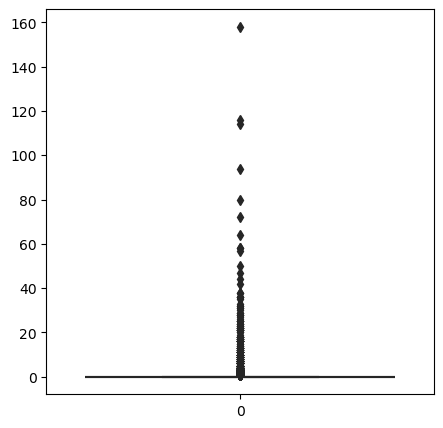

In [11]:
plt.figure(figsize=[5,5])
sns.boxplot(data['fat'], color='purple')
plt.show()

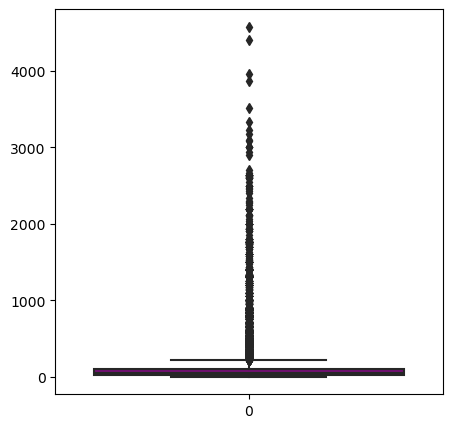

In [12]:
plt.figure(figsize=[5,5])
sns.boxplot(data['wid'], color='purple')
plt.show()

In [13]:
#data['len'] = mstats.winsorize(data['len'], limits=[0.01, 0.05])
#data['wid'] = mstats.winsorize(data['wid'], limits=[0.01, 0.05])
#data['inj'] = mstats.winsorize(data['inj'], limits=[0.01, 0.01])
#data['fat'] = mstats.winsorize(data['fat'], limits=[0.01, 0.01])

In [14]:
data.wid.unique()

array([ 130,  150,   10,   17,  100,  300,  133,  400,   67, 1000,   33,
        233,  833,   50,   27,  600,  200, 1760,   77,   37,  293,  440,
         30,  660,  467,  333,  250,   40,  880,  267,  700,  220,  167,
         90,   13,  500,  317,   20,  123,   73,  127,  900,  217,  450,
        173,  350,  330,  110,   57,  140,  230,  177,  587,  650,  417,
        427,   83,   60,   43, 1300,   70,  867,   80,  750,   23,   97,
        583,  433,  147,  667, 1417, 1320, 1480,   53,   47,  883,  137,
        210,  163,  800,  227, 1100,  790,  207,  223,   25,  313,  120,
         63,  367,  117, 1333,  533, 1200,  183, 1667,  320, 1500,  283,
        180,  280,  550,  187,  517, 2000,  817, 1400, 1600, 1167,  160,
        733,  327,  243,   87,  647,  527,  253,  143,  115,  277,   93,
       3000, 2667,  193, 2933,  360,  290, 2200, 1133, 2500,  213,  107,
       1700, 2630,  270, 1583,  373,  613,  850,  170,  420, 1056,  567,
        530, 1707, 1733, 2333,  847, 1533,  713, 10

In [15]:
column_names = {'mag': 'Magnitude',
                'inj': 'Injuries',
                'fat': 'Deaths',
                'st': 'State',
                'len': 'Length',
                'wid': 'Width'}
data.rename(columns=column_names, inplace=True)

In [16]:
data.head(10)

,yr,mo,dy,date,State,Magnitude,Injuries,Deaths,slat,slon,elat,elon,Length,Width,state_encoded
0,1950,1,3,1950-01-03,IL,3,3,0,39.10,-89.30,39.12,-89.23,3.6,130,14
1,1950,1,3,1950-01-03,MO,3,3,0,38.77,-90.22,38.83,-90.03,9.5,150,24
2,1950,1,3,1950-01-03,OH,1,1,0,40.88,-84.58,0.00,0.00,0.1,10,35
3,1950,1,13,1950-01-13,AR,3,1,1,34.40,-94.37,0.00,0.00,0.6,17,2
4,1950,1,25,1950-01-25,IL,2,0,0,41.17,-87.33,0.00,0.00,0.1,100,14
5,1950,1,25,1950-01-25,MO,2,5,0,37.60,-90.68,37.63,-90.65,2.3,300,24
6,1950,1,26,1950-01-26,TX,2,2,0,26.88,-98.12,26.88,-98.05,4.7,133,44
7,1950,2,11,1950-02-11,TX,2,0,0,29.42,-95.25,29.52,-95.13,9.9,400,44
8,1950,2,11,1950-02-11,TX,2,5,0,32.35,-95.20,32.42,-95.20,4.6,100,44
9,1950,2,11,1950-02-11,TX,2,6,0,32.98,-94.63,33.00,-94.70,4.5,67,44


In [17]:
##dataset 2
weather_data = pd.read_parquet('daily_weather.parquet')
weather_data.head()

,station_id,city_name,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min
0,41515,Asadabad,1957-07-01,Summer,27.0,21.1,35.6,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,41515,Asadabad,1957-07-02,Summer,22.8,18.9,32.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,41515,Asadabad,1957-07-03,Summer,24.3,16.7,35.6,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,41515,Asadabad,1957-07-04,Summer,26.6,16.1,37.8,4.1,NaN,NaN,NaN,NaN,NaN,NaN
4,41515,Asadabad,1957-07-05,Summer,30.8,20.0,41.7,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
city_data = pd.read_csv('weather_cities.csv')
city_data.head()

,station_id,city_name,country,state,iso2,iso3,latitude,longitude
0,41515,Asadabad,Afghanistan,Kunar,AF,AFG,34.866000,71.150005
1,38954,Fayzabad,Afghanistan,Badakhshan,AF,AFG,37.129761,70.579247
2,41560,Jalalabad,Afghanistan,Nangarhar,AF,AFG,34.441527,70.436103
3,38947,Kunduz,Afghanistan,Kunduz,AF,AFG,36.727951,68.872530
4,38987,Qala i Naw,Afghanistan,Badghis,AF,AFG,34.983000,63.133300


In [19]:
weather_data = pd.merge(weather_data, city_data, on='station_id', how='left')
weather_data.head()

,station_id,city_name_x,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,...,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min,city_name_y,country,state,iso2,iso3,latitude,longitude
0,41515,Asadabad,1957-07-01,Summer,27.0,21.1,35.6,0.0,NaN,NaN,...,NaN,NaN,NaN,Asadabad,Afghanistan,Kunar,AF,AFG,34.866,71.150005
1,41515,Asadabad,1957-07-02,Summer,22.8,18.9,32.2,0.0,NaN,NaN,...,NaN,NaN,NaN,Asadabad,Afghanistan,Kunar,AF,AFG,34.866,71.150005
2,41515,Asadabad,1957-07-03,Summer,24.3,16.7,35.6,1.0,NaN,NaN,...,NaN,NaN,NaN,Asadabad,Afghanistan,Kunar,AF,AFG,34.866,71.150005
3,41515,Asadabad,1957-07-04,Summer,26.6,16.1,37.8,4.1,NaN,NaN,...,NaN,NaN,NaN,Asadabad,Afghanistan,Kunar,AF,AFG,34.866,71.150005
4,41515,Asadabad,1957-07-05,Summer,30.8,20.0,41.7,0.0,NaN,NaN,...,NaN,NaN,NaN,Asadabad,Afghanistan,Kunar,AF,AFG,34.866,71.150005


In [20]:
us_count = weather_data['country'].value_counts().get('United States of America', 0)
print(us_count)

1481287


In [21]:
weather_data = weather_data[weather_data['country'] == 'United States of America']
weather_data.head()

,station_id,city_name_x,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,...,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min,city_name_y,country,state,iso2,iso3,latitude,longitude
25761028,72518,Albany,1938-06-01,Summer,NaN,8.3,26.7,0.0,0.0,NaN,...,NaN,NaN,NaN,Albany,United States of America,New York,US,USA,42.670017,-73.819949
25761029,72518,Albany,1938-06-02,Summer,NaN,9.4,26.1,5.1,0.0,NaN,...,NaN,NaN,NaN,Albany,United States of America,New York,US,USA,42.670017,-73.819949
25761030,72518,Albany,1938-06-03,Summer,NaN,13.9,23.3,4.1,0.0,NaN,...,NaN,NaN,NaN,Albany,United States of America,New York,US,USA,42.670017,-73.819949
25761031,72518,Albany,1938-06-04,Summer,NaN,9.4,25.0,0.0,0.0,NaN,...,NaN,NaN,NaN,Albany,United States of America,New York,US,USA,42.670017,-73.819949
25761032,72518,Albany,1938-06-05,Summer,NaN,13.3,22.2,0.0,0.0,NaN,...,NaN,NaN,NaN,Albany,United States of America,New York,US,USA,42.670017,-73.819949


In [22]:
month_to_season = {
    1: 'Winter',
    2: 'Winter',
    3: 'Spring',
    4: 'Spring',
    5: 'Spring',
    6: 'Summer',
    7: 'Summer',
    8: 'Summer',
    9: 'Fall',
    10: 'Fall',
    11: 'Fall',
    12: 'Winter'
}

weather_data['month'] = pd.to_datetime(weather_data['date']).dt.month
weather_data['season'] = weather_data['season'].fillna(weather_data['month'].map(month_to_season))

weather_data.drop(columns=['month'], inplace=True)

In [23]:
print("Total NaN in Season:", weather_data.season.isnull().sum())

Total NaN in Season: 0


In [24]:
weather_data.shape

(1481287, 21)

In [25]:
weather_data.date.duplicated().sum()

1430272

In [26]:
data.State.unique()

array(['IL', 'MO', 'OH', 'AR', 'TX', 'LA', 'MS', 'TN', 'OK', 'FL', 'AL',
       'SC', 'KS', 'IA', 'NE', 'SD', 'WY', 'NC', 'GA', 'ND', 'MN', 'WI',
       'IN', 'PA', 'NM', 'CT', 'CO', 'WV', 'MD', 'KY', 'CA', 'VA', 'NJ',
       'MI', 'MA', 'NH', 'OR', 'NY', 'MT', 'AZ', 'UT', 'ME', 'VT', 'ID',
       'WA', 'DE', 'HI', 'PR', 'AK', 'NV', 'RI', 'DC', 'VI'], dtype=object)

In [27]:
state_mapping = {
    'Illinois': 'IL', 'Missouri': 'MO', 'Ohio': 'OH', 'Arkansas': 'AR', 'Texas': 'TX',
    'Louisiana': 'LA', 'Mississippi': 'MS', 'Tennessee': 'TN', 'Oklahoma': 'OK', 'Florida': 'FL',
    'Alabama': 'AL', 'South Carolina': 'SC', 'Kansas': 'KS', 'Iowa': 'IA', 'Nebraska': 'NE',
    'South Dakota': 'SD', 'Wyoming': 'WY', 'North Carolina': 'NC', 'Georgia': 'GA', 'North Dakota': 'ND',
    'Minnesota': 'MN', 'Wisconsin': 'WI', 'Indiana': 'IN', 'Pennsylvania': 'PA', 'New Mexico': 'NM',
    'Connecticut': 'CT', 'Colorado': 'CO', 'West Virginia': 'WV', 'Maryland': 'MD', 'Kentucky': 'KY',
    'California': 'CA', 'Virginia': 'VA', 'New Jersey': 'NJ', 'Michigan': 'MI', 'Massachusetts': 'MA',
    'New Hampshire': 'NH', 'Oregon': 'OR', 'New York': 'NY', 'Montana': 'MT', 'Arizona': 'AZ',
    'Utah': 'UT', 'Maine': 'ME', 'Vermont': 'VT', 'Idaho': 'ID', 'Washington': 'WA', 'Delaware': 'DE',
    'Hawaii': 'HI', 'Puerto Rico': 'PR', 'Alaska': 'AK', 'Nevada': 'NV', 'Rhode Island': 'RI',
    'District of Columbia': 'DC', 'Virgin Islands': 'VI'
}

weather_data['state'] = weather_data['state'].map(state_mapping)

In [28]:
weather_data.state.unique()

array(['NY', 'MD', 'GA', 'ME', 'TX', 'ND', 'ID', 'MA', 'NV', 'WV', 'WY',
       'SC', 'OH', 'NH', 'CO', 'IA', 'DE', 'KY', 'PA', 'CT', 'MT', 'HI',
       'IN', 'MS', 'MO', 'AK', 'MI', 'NE', 'AR', 'WI', 'AL', 'VT', 'TN',
       'OK', 'WA', 'AZ', 'RI', 'NC', 'VA', 'CA', 'MN', 'OR', 'UT', 'NM',
       'IL', 'FL', 'KS', 'NJ', 'DC'], dtype=object)

In [29]:
statechange = {'state': 'State'}
weather_data.rename(columns=statechange, inplace=True)
weather_data.head(1)

,station_id,city_name_x,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,...,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min,city_name_y,country,State,iso2,iso3,latitude,longitude
25761028,72518,Albany,1938-06-01,Summer,NaN,8.3,26.7,0.0,0.0,NaN,...,NaN,NaN,NaN,Albany,United States of America,NY,US,USA,42.670017,-73.819949


In [30]:
weather_data.isnull().sum()

station_id                      0
city_name_x                     0
date                            0
season                          0
avg_temp_c                 545686
min_temp_c                   2584
max_temp_c                   2526
precipitation_mm            23241
snow_depth_mm              177509
avg_wind_dir_deg          1024517
avg_wind_speed_kmh         532918
peak_wind_gust_kmh        1048359
avg_sea_level_pres_hpa     617464
sunshine_total_min         971919
city_name_y                     0
country                         0
State                           0
iso2                            0
iso3                            0
latitude                        0
longitude                       0
dtype: int64

In [31]:
weather_data.isnull()

,station_id,city_name_x,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,...,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min,city_name_y,country,State,iso2,iso3,latitude,longitude
25761028,False,False,False,False,True,False,False,False,False,True,...,True,True,True,False,False,False,False,False,False,False
25761029,False,False,False,False,True,False,False,False,False,True,...,True,True,True,False,False,False,False,False,False,False
25761030,False,False,False,False,True,False,False,False,False,True,...,True,True,True,False,False,False,False,False,False,False
25761031,False,False,False,False,True,False,False,False,False,True,...,True,True,True,False,False,False,False,False,False,False
25761032,False,False,False,False,True,False,False,False,False,True,...,True,True,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27242310,False,False,False,False,False,False,False,True,True,False,...,True,False,True,False,False,False,False,False,False,False
27242311,False,False,False,False,False,False,False,True,True,False,...,True,False,True,False,False,False,False,False,False,False
27242312,False,False,False,False,False,False,False,True,True,False,...,True,False,True,False,False,False,False,False,False,False
27242313,False,False,False,False,False,False,False,True,True,False,...,True,False,True,False,False,False,False,False,False,False


In [32]:
precip_avg = weather_data.dropna(subset=['precipitation_mm']).groupby(['State', 'season'])['precipitation_mm'].mean()

C:\Users\theel\AppData\Local\Temp\ipykernel_33980\2672039020.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  precip_avg = weather_data.dropna(subset=['precipitation_mm']).groupby(['State', 'season'])['precipitation_mm'].mean()


In [33]:
precip_avg.NY.head

<bound method NDFrame.head of season
Autumn    2.707020
Spring    2.582427
Summer    3.002769
Winter    2.163742
Name: precipitation_mm, dtype: float64>

In [34]:
weather_data = pd.merge(weather_data, precip_avg.reset_index(), on=['State', 'season'], how='left', suffixes=('','_avg'))
weather_data.precipitation_mm_avg.head()

0    3.002769
1    3.002769
2    3.002769
3    3.002769
4    3.002769
Name: precipitation_mm_avg, dtype: float64

In [35]:
weather_data['precipitation_mm'].fillna(weather_data['precipitation_mm_avg'], inplace=True)
weather_data.drop(columns=['precipitation_mm_avg'], inplace=True)
weather_data.head()

,station_id,city_name_x,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,...,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min,city_name_y,country,State,iso2,iso3,latitude,longitude
0,72518,Albany,1938-06-01,Summer,NaN,8.3,26.7,0.0,0.0,NaN,...,NaN,NaN,NaN,Albany,United States of America,NY,US,USA,42.670017,-73.819949
1,72518,Albany,1938-06-02,Summer,NaN,9.4,26.1,5.1,0.0,NaN,...,NaN,NaN,NaN,Albany,United States of America,NY,US,USA,42.670017,-73.819949
2,72518,Albany,1938-06-03,Summer,NaN,13.9,23.3,4.1,0.0,NaN,...,NaN,NaN,NaN,Albany,United States of America,NY,US,USA,42.670017,-73.819949
3,72518,Albany,1938-06-04,Summer,NaN,9.4,25.0,0.0,0.0,NaN,...,NaN,NaN,NaN,Albany,United States of America,NY,US,USA,42.670017,-73.819949
4,72518,Albany,1938-06-05,Summer,NaN,13.3,22.2,0.0,0.0,NaN,...,NaN,NaN,NaN,Albany,United States of America,NY,US,USA,42.670017,-73.819949


In [36]:
# someone left the game LOL TILTED
weather_data.query('precipitation_mm == 0')

,station_id,city_name_x,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,...,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min,city_name_y,country,State,iso2,iso3,latitude,longitude
0,72518,Albany,1938-06-01,Summer,NaN,8.3,26.7,0.0,0.0,NaN,...,NaN,NaN,NaN,Albany,United States of America,NY,US,USA,42.670017,-73.819949
3,72518,Albany,1938-06-04,Summer,NaN,9.4,25.0,0.0,0.0,NaN,...,NaN,NaN,NaN,Albany,United States of America,NY,US,USA,42.670017,-73.819949
4,72518,Albany,1938-06-05,Summer,NaN,13.3,22.2,0.0,0.0,NaN,...,NaN,NaN,NaN,Albany,United States of America,NY,US,USA,42.670017,-73.819949
5,72518,Albany,1938-06-06,Summer,NaN,7.2,26.1,0.0,0.0,NaN,...,NaN,NaN,NaN,Albany,United States of America,NY,US,USA,42.670017,-73.819949
6,72518,Albany,1938-06-07,Summer,NaN,17.2,31.7,0.0,0.0,NaN,...,NaN,NaN,NaN,Albany,United States of America,NY,US,USA,42.670017,-73.819949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481269,72405,Washington,2023-08-19,Summer,23.2,17.8,28.9,0.0,NaN,276.0,...,NaN,1018.0,NaN,Washington,United States of America,DC,US,USA,38.899549,-77.009419
1481270,72405,Washington,2023-08-20,Summer,24.7,18.9,31.1,0.0,0.0,177.0,...,NaN,1019.7,NaN,Washington,United States of America,DC,US,USA,38.899549,-77.009419
1481271,72405,Washington,2023-08-21,Summer,27.6,22.8,33.3,0.0,0.0,323.0,...,NaN,1018.5,NaN,Washington,United States of America,DC,US,USA,38.899549,-77.009419
1481272,72405,Washington,2023-08-22,Summer,26.9,21.1,28.9,0.0,0.0,11.0,...,NaN,1018.4,NaN,Washington,United States of America,DC,US,USA,38.899549,-77.009419


In [37]:
weather_data.precipitation_mm.isnull().sum()


0

In [38]:
weather_data.dtypes

station_id                        object
city_name_x                     category
date                      datetime64[us]
season                          category
avg_temp_c                       float64
min_temp_c                       float64
max_temp_c                       float64
precipitation_mm                 float64
snow_depth_mm                    float64
avg_wind_dir_deg                 float64
avg_wind_speed_kmh               float64
peak_wind_gust_kmh               float64
avg_sea_level_pres_hpa           float64
sunshine_total_min               float64
city_name_y                       object
country                           object
State                             object
iso2                              object
iso3                              object
latitude                         float64
longitude                        float64
dtype: object

In [39]:
us_count = weather_data['precipitation_mm'].value_counts().get(2.5, 0)
print(us_count)

10603


In [40]:
data.shape

(67558, 15)

In [41]:
data['date'] = pd.to_datetime(data['date'])

In [42]:
tornado_data = pd.merge(data, weather_data, on=['date', 'State'], how='left')
tornado_data.shape

(67558, 34)

In [43]:
tornado_data.isnull().sum()

yr                            0
mo                            0
dy                            0
date                          0
State                         0
Magnitude                     0
Injuries                      0
Deaths                        0
slat                          0
slon                          0
elat                          0
elon                          0
Length                        0
Width                         0
state_encoded                 0
station_id                 6369
city_name_x                6369
season                     6369
avg_temp_c                23507
min_temp_c                 6373
max_temp_c                 6373
precipitation_mm           6369
snow_depth_mm             11010
avg_wind_dir_deg          43928
avg_wind_speed_kmh        20315
peak_wind_gust_kmh        47434
avg_sea_level_pres_hpa    31575
sunshine_total_min        39793
city_name_y                6369
country                    6369
iso2                       6369
iso3    

In [44]:
drop_columns = ['country', 'iso2', 'iso3', 'latitude', 'longitude', 'station_id', 'sunshine_total_min', 'avg_sea_level_pres_hpa',
               'peak_wind_gust_kmh', 'avg_wind_dir_deg', 'snow_depth_mm', 'avg_wind_speed_kmh', 'city_name_x', 'city_name_y']
tornado_data.drop(columns=drop_columns, inplace=True)

In [45]:
tornado_data.isnull().sum()

yr                      0
mo                      0
dy                      0
date                    0
State                   0
Magnitude               0
Injuries                0
Deaths                  0
slat                    0
slon                    0
elat                    0
elon                    0
Length                  0
Width                   0
state_encoded           0
season               6369
avg_temp_c          23507
min_temp_c           6373
max_temp_c           6373
precipitation_mm     6369
dtype: int64

In [46]:
tornado_data.season.unique()

['Winter', NaN, 'Spring', 'Summer', 'Autumn']
Categories (4, object): ['Autumn', 'Spring', 'Summer', 'Winter']

In [47]:
#Funtion to fill NaN values in the [Season] column, based on the month provided in [Date]
def get_season(month):
    if month in [3,4,5]:
        return 'Spring'
    elif month in [6,7,8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

In [48]:
print("Season NaN total:", tornado_data.season.isnull().sum())
tornado_data['season'] = tornado_data['season'].fillna(tornado_data['mo'].apply(get_season))
print("Season NaN total:", tornado_data.season.isnull().sum())

Season NaN total: 6369
Season NaN total: 0


### Temperature Analysis (Future Work)

---

In [49]:
tornado_data.head()

,yr,mo,dy,date,State,Magnitude,Injuries,Deaths,slat,slon,elat,elon,Length,Width,state_encoded,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm
0,1950,1,3,1950-01-03,IL,3,3,0,39.10,-89.30,39.12,-89.23,3.6,130,14,Winter,NaN,-6.1,15.6,31.5
1,1950,1,3,1950-01-03,MO,3,3,0,38.77,-90.22,38.83,-90.03,9.5,150,24,Winter,NaN,NaN,NaN,NaN
2,1950,1,3,1950-01-03,OH,1,1,0,40.88,-84.58,0.00,0.00,0.1,10,35,Winter,13.2,11.7,17.8,17.5
3,1950,1,13,1950-01-13,AR,3,1,1,34.40,-94.37,0.00,0.00,0.6,17,2,Winter,NaN,NaN,NaN,NaN
4,1950,1,25,1950-01-25,IL,2,0,0,41.17,-87.33,0.00,0.00,0.1,100,14,Winter,NaN,-2.8,21.1,19.6


In [50]:
#Fill [min_temp_c] and [max_temp_c] with average temp according to season.
avg_temps = tornado_data.groupby('season')[['min_temp_c', 'max_temp_c']].median()

for season, avg_temp_row in avg_temps.iterrows():
    tornado_data.loc[tornado_data['season'] == season, 'min_temp_c'] = tornado_data.loc[tornado_data['season'] == season, 'min_temp_c'].fillna(avg_temp_row['min_temp_c'])
    tornado_data.loc[tornado_data['season'] == season, 'max_temp_c'] = tornado_data.loc[tornado_data['season'] == season, 'max_temp_c'].fillna(avg_temp_row['max_temp_c'])

C:\Users\theel\AppData\Local\Temp\ipykernel_33980\200121479.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_temps = tornado_data.groupby('season')[['min_temp_c', 'max_temp_c']].median()


In [51]:
#To fill the [avg_temp_c], I took the average of the min and max temps to get a more accurate estimate.
tornado_data['avg_temp_c'] = tornado_data['avg_temp_c'].fillna((tornado_data['min_temp_c'] + tornado_data['max_temp_c']) / 2)

In [52]:
tornado_data.isnull().sum()

yr                     0
mo                     0
dy                     0
date                   0
State                  0
Magnitude              0
Injuries               0
Deaths                 0
slat                   0
slon                   0
elat                   0
elon                   0
Length                 0
Width                  0
state_encoded          0
season                 0
avg_temp_c             0
min_temp_c             0
max_temp_c             0
precipitation_mm    6369
dtype: int64

---

In [53]:
for i, row in tornado_data.iterrows():
    state = row['State']
    season = row['season']
    if pd.isna(row['precipitation_mm']):
        tornado_data.at[i, 'precipitation_mm'] = precip_avg.get((state, season), None)

tornado_data.precipitation_mm.isnull().sum()

4112

In [54]:
tornado_data = tornado_data.dropna()
tornado_data.isnull().sum()

yr                  0
mo                  0
dy                  0
date                0
State               0
Magnitude           0
Injuries            0
Deaths              0
slat                0
slon                0
elat                0
elon                0
Length              0
Width               0
state_encoded       0
season              0
avg_temp_c          0
min_temp_c          0
max_temp_c          0
precipitation_mm    0
dtype: int64

In [55]:
tornado_data.head()

,yr,mo,dy,date,State,Magnitude,Injuries,Deaths,slat,slon,elat,elon,Length,Width,state_encoded,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm
0,1950,1,3,1950-01-03,IL,3,3,0,39.10,-89.30,39.12,-89.23,3.6,130,14,Winter,4.75,-6.1,15.6,31.500000
1,1950,1,3,1950-01-03,MO,3,3,0,38.77,-90.22,38.83,-90.03,9.5,150,24,Winter,13.60,7.8,19.4,1.773296
2,1950,1,3,1950-01-03,OH,1,1,0,40.88,-84.58,0.00,0.00,0.1,10,35,Winter,13.20,11.7,17.8,17.500000
3,1950,1,13,1950-01-13,AR,3,1,1,34.40,-94.37,0.00,0.00,0.6,17,2,Winter,13.60,7.8,19.4,3.509785
4,1950,1,25,1950-01-25,IL,2,0,0,41.17,-87.33,0.00,0.00,0.1,100,14,Winter,9.15,-2.8,21.1,19.600000


### Normalization

In [56]:
standardize = tornado_data[['Injuries', 'Deaths', 'Length', 'Width', 'avg_temp_c', 'min_temp_c', 'max_temp_c', 'precipitation_mm']]
other_data = tornado_data[['Magnitude','yr', 'mo', 'dy', 'date', 'State', 'state_encoded', 'slat', 'slon', 'elat', 'elon']]
s_tornado_data = standard_scaler.fit_transform(standardize)
s_tornado_data = pd.concat([pd.DataFrame(s_tornado_data, columns=standardize.columns), other_data], axis=1)
dtype_dict = {'yr': 'int32', 'mo': 'int32', 'dy': 'int32'}
s_tornado_data.head()

,Injuries,Deaths,Length,Width,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,Magnitude,yr,mo,dy,date,State,state_encoded,slat,slon,elat,elon
0,0.001724,0.000000,0.016529,0.028409,0.387457,0.212,0.377176,0.135542,3.0,1950.0,1.0,3.0,1950-01-03,IL,14.0,39.10,-89.30,39.12,-89.23
1,0.001724,0.000000,0.043618,0.032780,0.539519,0.490,0.450677,0.007630,3.0,1950.0,1.0,3.0,1950-01-03,MO,24.0,38.77,-90.22,38.83,-90.03
2,0.000575,0.000000,0.000459,0.002185,0.532646,0.568,0.419729,0.075301,1.0,1950.0,1.0,3.0,1950-01-03,OH,35.0,40.88,-84.58,0.00,0.00
3,0.000575,0.006329,0.002755,0.003715,0.539519,0.490,0.450677,0.015102,3.0,1950.0,1.0,13.0,1950-01-13,AR,2.0,34.40,-94.37,0.00,0.00
4,0.000000,0.000000,0.000459,0.021853,0.463058,0.278,0.483559,0.084337,2.0,1950.0,1.0,25.0,1950-01-25,IL,14.0,41.17,-87.33,0.00,0.00


## Data Exploration
---

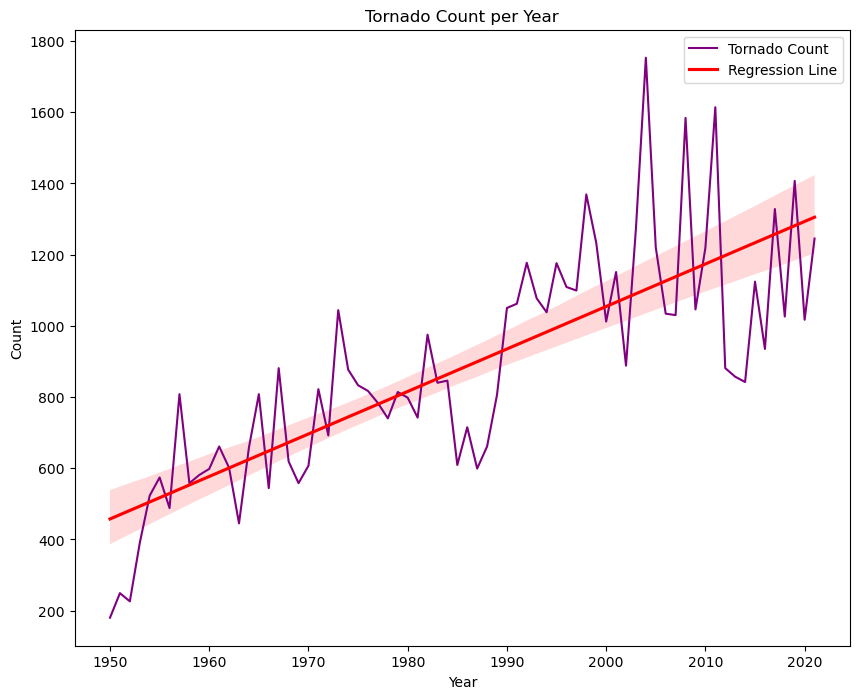

In [57]:
tornado_count = s_tornado_data.groupby('yr').Magnitude.count()

plt.figure(figsize=[10, 8])
plt.plot(tornado_count.index, tornado_count, color='purple', label='Tornado Count')
sns.regplot(x=tornado_count.index, y=tornado_count, scatter=False, color='red', label='Regression Line') 
plt.title('Tornado Count per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.show()

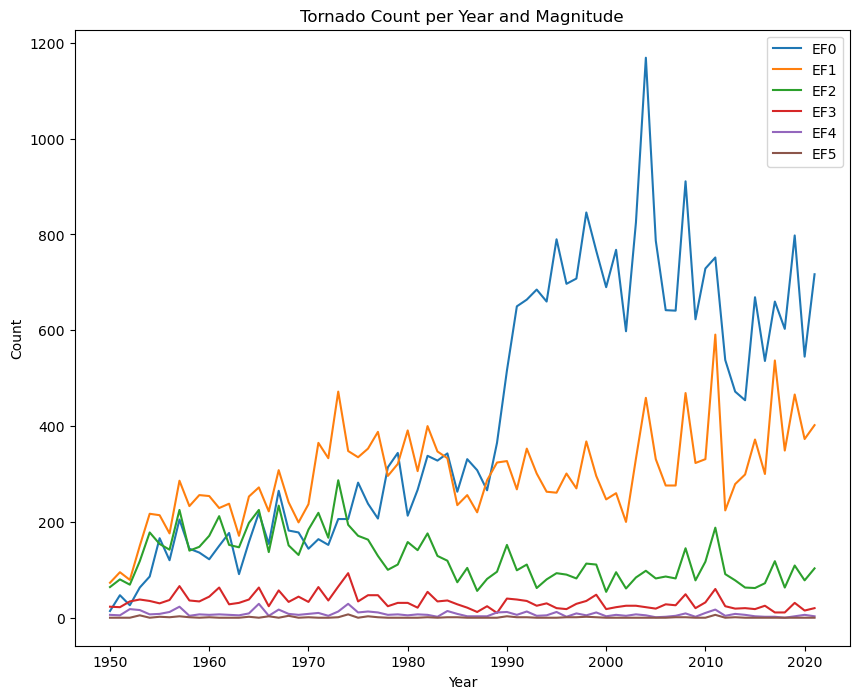

In [58]:
tornado_counts = s_tornado_data.groupby(['yr', 'Magnitude']).size().unstack(fill_value=0)

x = tornado_counts.index.values

plt.figure(figsize=[10, 8])

for magnitude in range(0, 6):
    y = tornado_counts[magnitude].values
    plt.plot(x, y, label=f'EF{magnitude}')

plt.title('Tornado Count per Year and Magnitude')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.show()

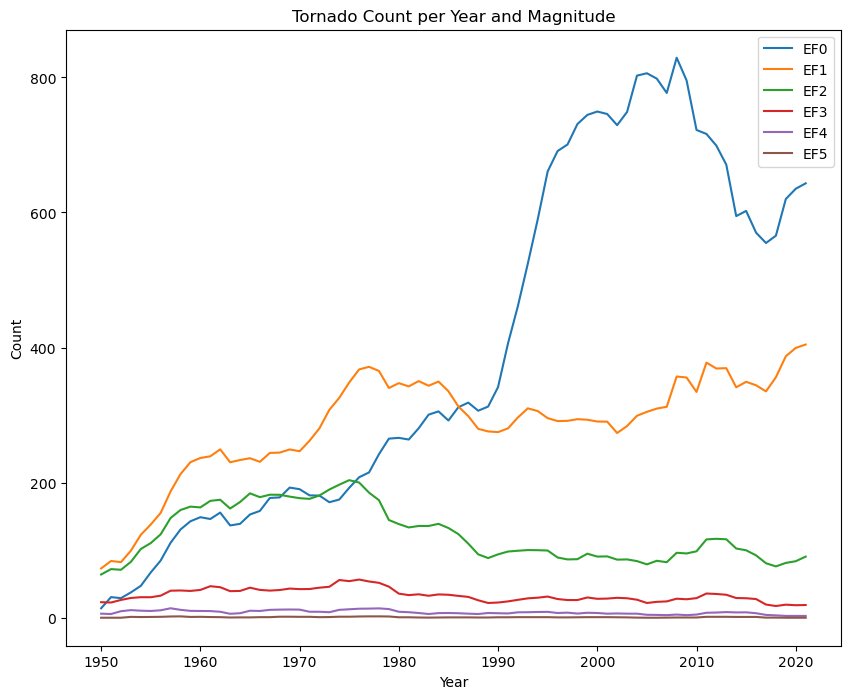

In [59]:
rolling_avg = tornado_counts.rolling(window=6, min_periods=1).mean()

x = rolling_avg.index.values

plt.figure(figsize=[10, 8])

# Plot each magnitude level as a separate line
for magnitude in range(0, 6):
    y = rolling_avg[magnitude].values
    plt.plot(x, y, label=f'EF{magnitude}')
    
plt.title('Tornado Count per Year and Magnitude')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.show()

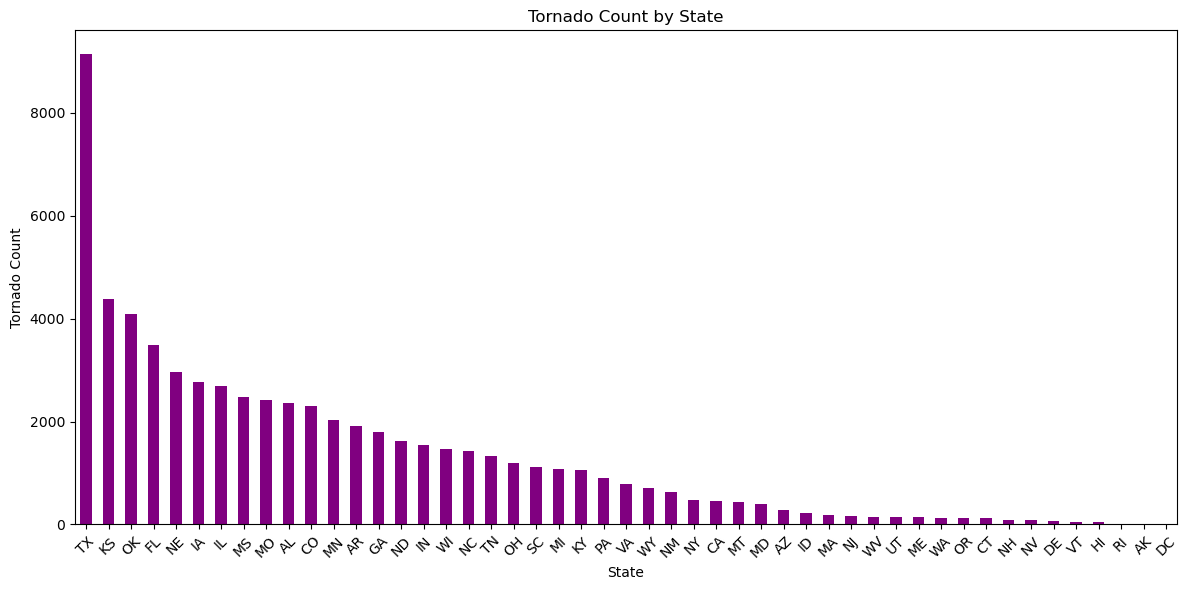

In [60]:
state_counts = s_tornado_data['State'].value_counts()

plt.figure(figsize=[12,6])
state_counts.plot(kind='bar', color='purple')

plt.xlabel('State')
plt.ylabel('Tornado Count')
plt.title('Tornado Count by State')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

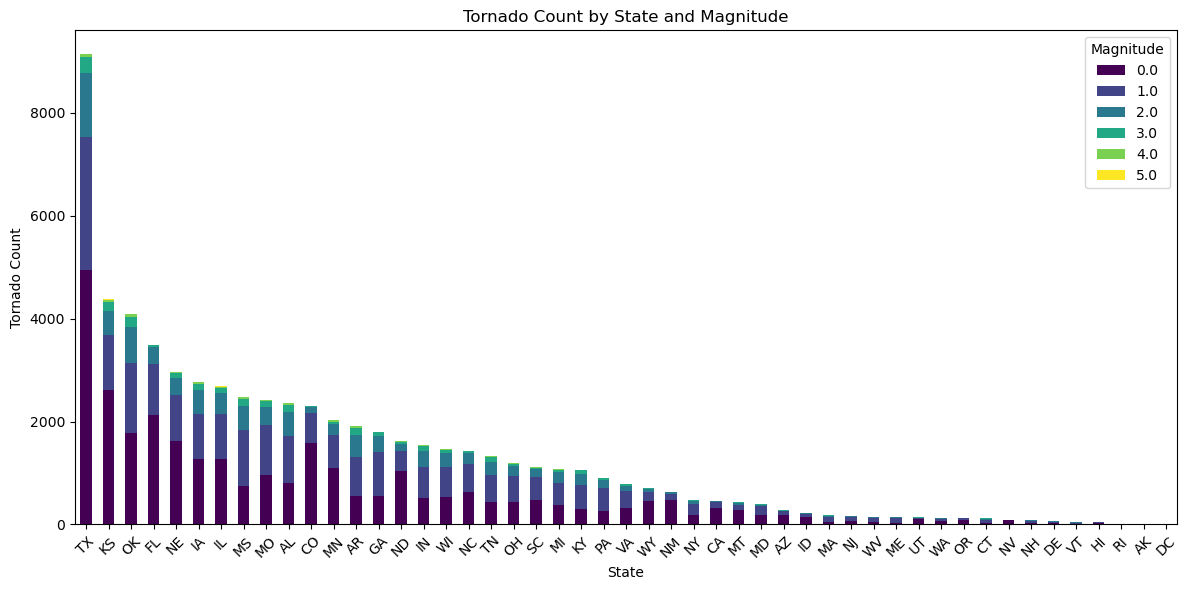

In [61]:
state_magnitude = s_tornado_data.groupby(['State', 'Magnitude']).size().unstack(fill_value=0)

state_magnitude_sorted = state_magnitude.sum(axis=1).sort_values(ascending=False)
state_magnitude_sorted = state_magnitude.loc[state_magnitude_sorted.index]

fig, ax = plt.subplots(figsize=(12, 6))
state_magnitude_sorted.plot(kind='bar', stacked=True, cmap='viridis', ax=ax)
ax.set_xlabel('State')
ax.set_ylabel('Tornado Count')
ax.set_title('Tornado Count by State and Magnitude')
ax.tick_params(axis='x', rotation=45)
ax.legend(title='Magnitude')
plt.tight_layout()
plt.show()

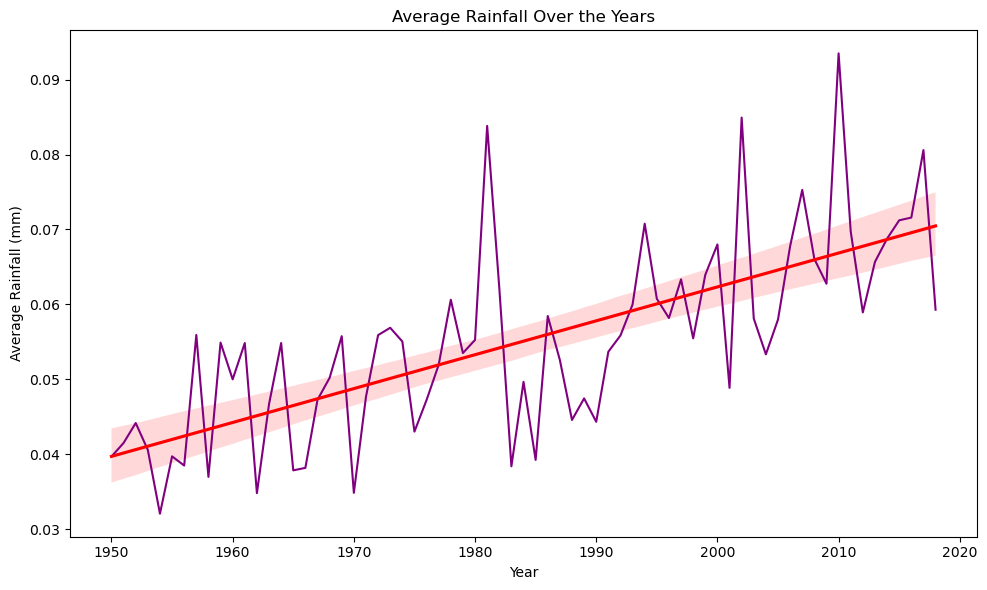

In [62]:
#gets average precipitation grouped by year
rainfall_avg = s_tornado_data.groupby('yr')['precipitation_mm'].mean()

plt.figure(figsize=(10, 6))
plt.plot(rainfall_avg.index, rainfall_avg, color='purple')
sns.regplot(x=rainfall_avg.index, y=rainfall_avg, scatter=False, color='red')
plt.xlabel('Year')
plt.ylabel('Average Rainfall (mm)')
plt.title('Average Rainfall Over the Years')
plt.tight_layout()
plt.show()

C:\Users\theel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\theel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


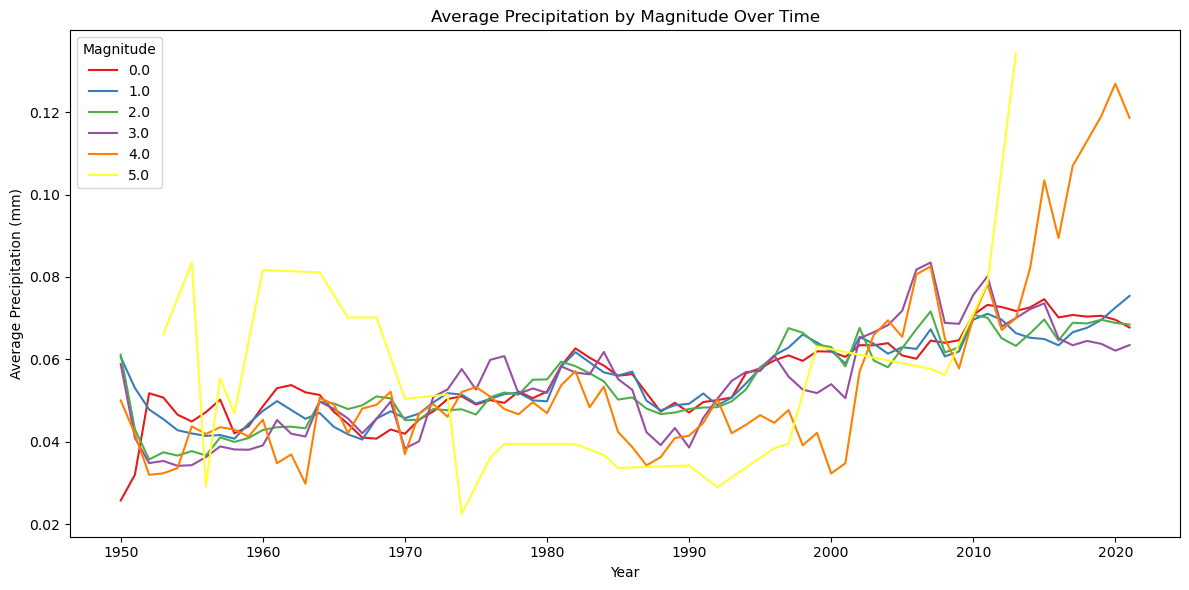

In [63]:
avg_precipitation_by_magnitude = s_tornado_data.groupby(['Magnitude', 'yr'])['precipitation_mm'].mean().reset_index()
avg_precipitation_by_magnitude['precipitation_mm'] = avg_precipitation_by_magnitude['precipitation_mm'].rolling(window=6, min_periods=1).mean()

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_precipitation_by_magnitude, x='yr', y='precipitation_mm', hue='Magnitude', palette='Set1')
plt.xlabel('Year')
plt.ylabel('Average Precipitation (mm)')
plt.title('Average Precipitation by Magnitude Over Time')
plt.legend(title='Magnitude')
plt.tight_layout()
plt.show()

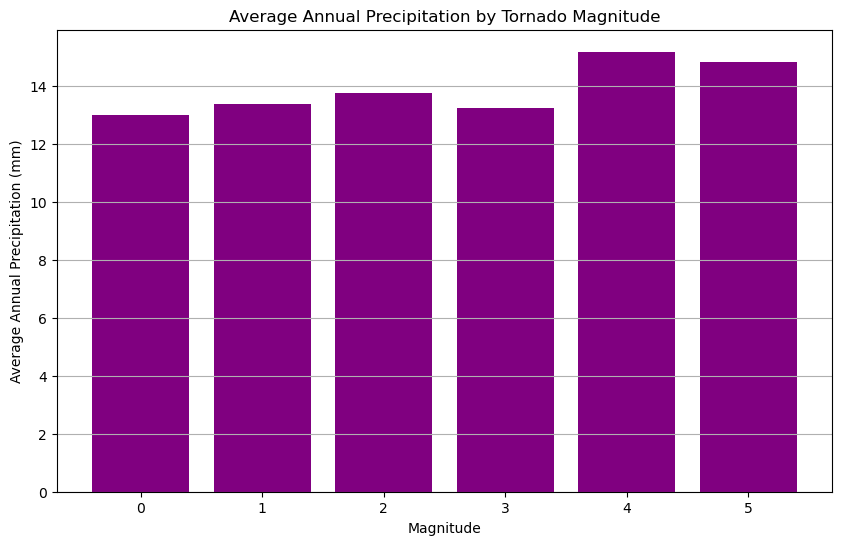

In [64]:
#Groups precipiation avg according to Magnitude and State
avg_precipitation_per_magnitude_state = tornado_data.groupby(['Magnitude', 'State'])['precipitation_mm'].mean().reset_index()

#Using the avg according to Magnitude and State to compute average precipitation per Magnitude
avg_precipitation_per_magnitude = avg_precipitation_per_magnitude_state.groupby('Magnitude')['precipitation_mm'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(avg_precipitation_per_magnitude['Magnitude'], avg_precipitation_per_magnitude['precipitation_mm'], color='purple')
plt.xlabel('Magnitude')
plt.ylabel('Average Annual Precipitation (mm)')
plt.title('Average Annual Precipitation by Tornado Magnitude')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

## Correlation Analysis

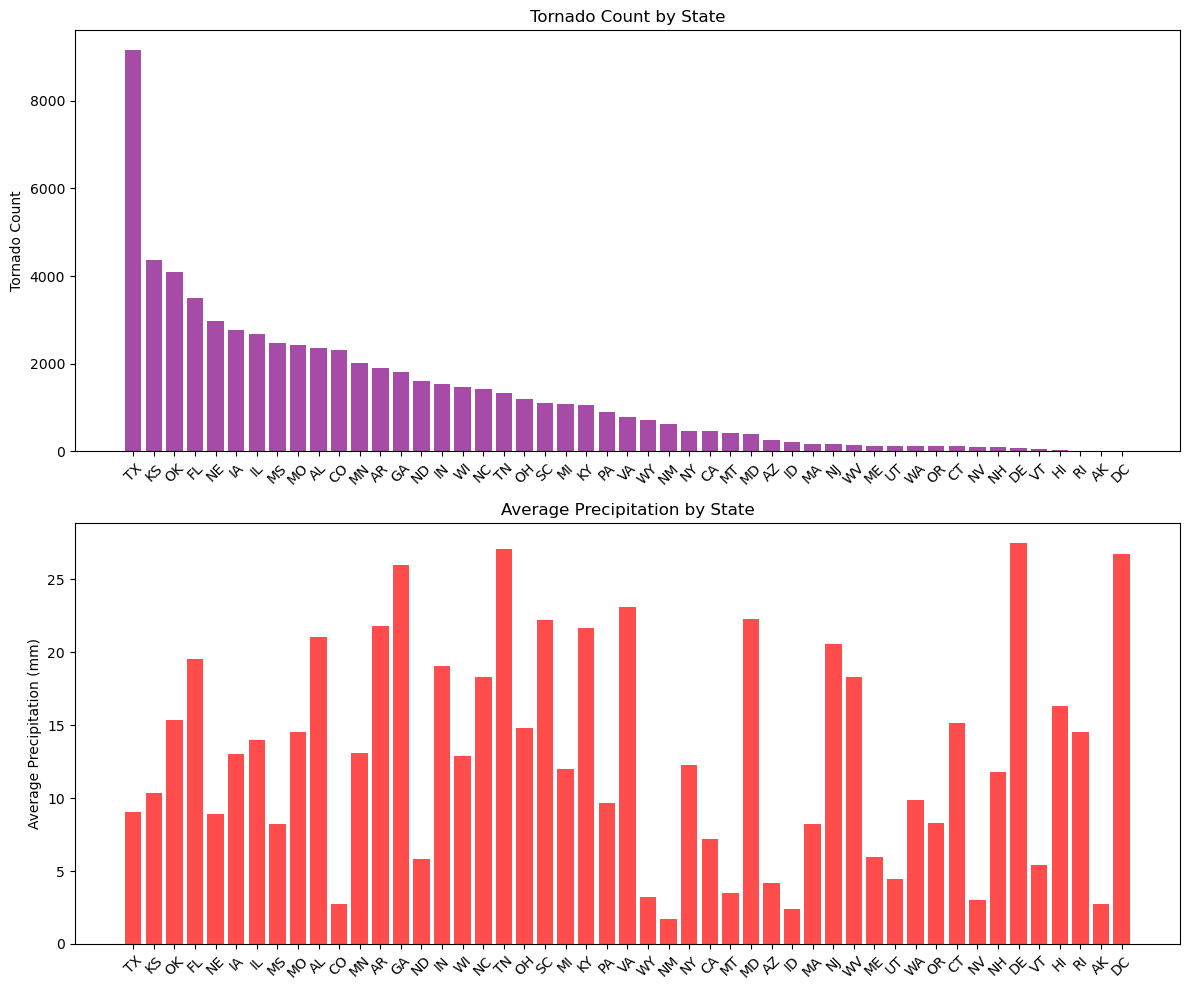

In [65]:
tornado_count_per_state = tornado_data.groupby('State').size().reset_index(name='Tornado Count')
tornado_count_per_state = tornado_count_per_state.sort_values(by='Tornado Count', ascending=False)

average_precipitation_per_state = tornado_data.groupby(['State', 'state_encoded'])['precipitation_mm'].mean().reset_index(name='Average Precipitation')
average_precipitation_per_state = average_precipitation_per_state.sort_values(by='State')

merged_data = pd.merge(tornado_count_per_state, average_precipitation_per_state, on='State', how='inner')

fig, axs = plt.subplots(2, 1, figsize=(12, 10))

axs[0].bar(merged_data['State'], merged_data['Tornado Count'], color='purple', alpha=0.7)
axs[0].set_ylabel('Tornado Count')
axs[0].set_title('Tornado Count by State')
axs[0].tick_params(axis='x', rotation=45)

axs[1].bar(merged_data['State'], merged_data['Average Precipitation'], color='red', alpha=0.7)
axs[1].set_ylabel('Average Precipitation (mm)')
axs[1].set_title('Average Precipitation by State')
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

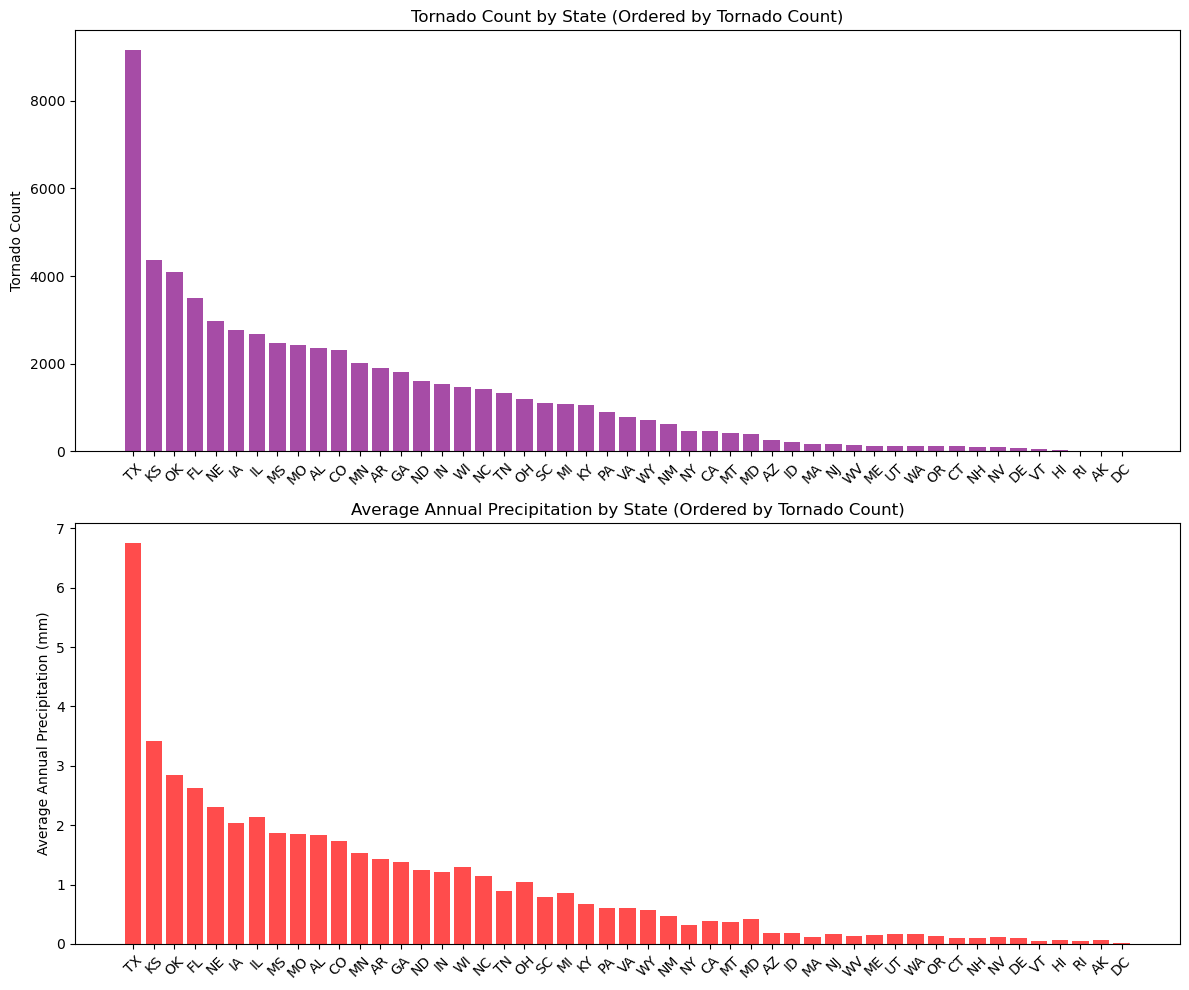

In [66]:
total_precipitation_per_state_year = s_tornado_data.groupby(['State', 'state_encoded', 'yr'])['precipitation_mm'].sum().reset_index()

average_annual_precipitation_per_state = total_precipitation_per_state_year.groupby(['State', 'state_encoded'])['precipitation_mm'].mean().reset_index(name='Average Annual Precipitation')
average_annual_precipitation_per_state = average_annual_precipitation_per_state.sort_values(by='Average Annual Precipitation', ascending=False)

tornado_count_per_state = data.groupby('State').size().reset_index(name='Tornado Count')
tornado_count_per_state = tornado_count_per_state.sort_values(by='Tornado Count', ascending=False)

merged_data = pd.merge(tornado_count_per_state, average_annual_precipitation_per_state, on='State', how='inner')

fig, axs = plt.subplots(2, 1, figsize=(12, 10))
axs[0].bar(merged_data['State'], merged_data['Tornado Count'], color='purple', alpha=0.7)
axs[0].set_ylabel('Tornado Count')
axs[0].set_title('Tornado Count by State (Ordered by Tornado Count)')
axs[0].tick_params(axis='x', rotation=45)

axs[1].bar(merged_data['State'], merged_data['Average Annual Precipitation'], color='red', alpha=0.7)
axs[1].set_ylabel('Average Annual Precipitation (mm)')
axs[1].set_title('Average Annual Precipitation by State (Ordered by Tornado Count)')
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

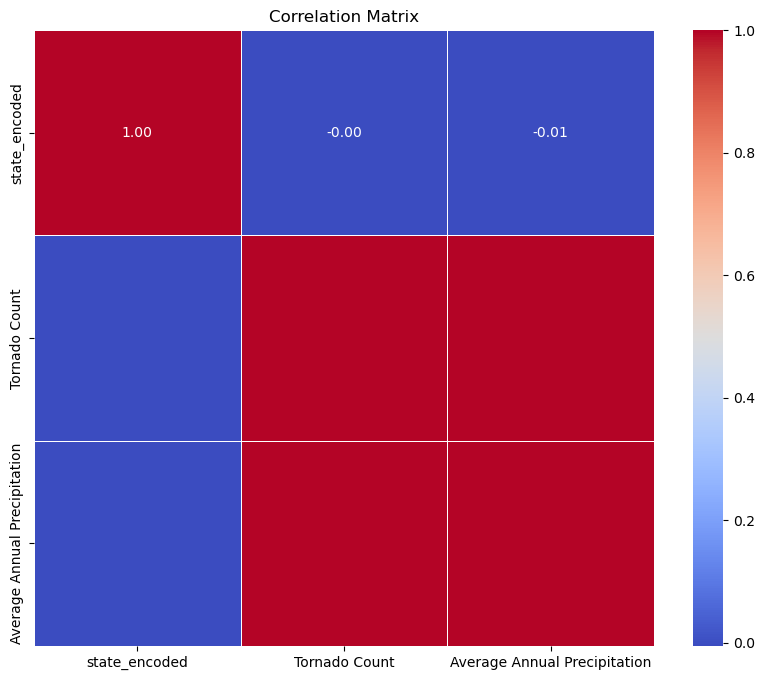

Summary Statistics:
       state_encoded  Tornado Count  Average Annual Precipitation
count       3.000000       3.000000                      3.000000
mean        0.330503       0.665178                      0.664267
std         0.579803       0.578555                      0.580133
min        -0.005613      -0.002879                     -0.005613
25%        -0.004246       0.497767                      0.496400
50%        -0.002879       0.998414                      0.998414
75%         0.498561       0.999207                      0.999207
max         1.000000       1.000000                      1.000000
Correlation Coefficient: 0.9984135890457414


In [67]:
matrix = merged_data[['state_encoded', 'Tornado Count', 'Average Annual Precipitation']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

summary_statistics = matrix.describe()
print("Summary Statistics:")
print(summary_statistics)
correlation_coefficient = merged_data['Tornado Count'].corr(merged_data['Average Annual Precipitation'])
print(f"Correlation Coefficient: {correlation_coefficient}")

In [68]:
pearson_corr_coef, pearson_p_value = pearsonr(matrix['Average Annual Precipitation'], matrix['Tornado Count'])
print("Pearson correlation coefficient:", pearson_corr_coef)
print("Pearson correlation p-value:", pearson_p_value)

Pearson correlation coefficient: 0.9999962508765698
Pearson correlation p-value: 0.0017432518141106534


In [69]:
s_tornado_data.to_csv("C:/Users/theel/Desktop/s_tornado_data.csv")
tornado_data.to_csv("C:/Users/theel/Desktop/tornado_data.csv")
merged_data.to_csv("C:/Users/theel/Desktop/merged_tornado_data.csv")